In [1]:
from dataset import MetaHDFDataset
import pickle
import torch
import torch.nn as nn
import random
import re
import time
import numpy as np
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# device = "cpu"

In [2]:
metadataset = pickle.load(open('pushing.pickle',"rb"))

N_of_metatrain_trajs = len(metadataset.MTRAIN) #240
N_of_metaval_trajs = len(metadataset.MVAL) #30
N_of_metatest_trajs = len(metadataset.MTEST) #30

In [3]:
#Parameters

# Hyperparameters
traj_batch = 5
n_epochs = 10000
hidden_size = 800
n_layers = 2
learning_rate = 0.001
model_type = 'gru'
print_every = 50
plot_every = 50
bidir = False

In [4]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: K input trajectory of pusher and N obejcts (K,N+1,timesteps,6) a list of lists of numpy arrays
    - target: target predictions (K,N,timesteps, 3)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """

    k = len(input)
    timesteps,_ = np.shape(input[0][0])
    hidden_layer = rnn.init_hidden(timesteps,device)
    rnn.zero_grad()
    optimizer.zero_grad()
    loss = 0.
    
    for traj in range(k):
        loss_tmp = 0.
        for o in range(len(input[traj])):
            output, hidden_layer = rnn(torch.from_numpy(input[traj][o]).to(device),hidden_layer)
            if o > 0:
                loss_tmp += criterion(output,torch.from_numpy(target[traj][o-1]).float().to(device))
        loss += loss_tmp/len(input[traj])
            
    loss = loss/k
    loss.backward()
    optimizer.step()
        
    return loss

def generate_random_data(N_of_trajs,all_trajs):
    """
    Output:
    ---------
    generates train and val input and output data in numpy array
    
    
    """
    indeces = np.random.choice(len(all_trajs),N_of_trajs)
    train_input_data = []
    train_output_data = []
    val_input_data = []
    val_output_data = []
    
    for i in indeces:
        train_input_traj = []
        train_output_traj = []
        val_input_traj = []
        val_output_traj = []
        
        timesteps,d = all_trajs[i].TrainInput.shape
        N = int(d/6)
        for j in range(N):
            if j == 0:
#                 print(all_trajs[i].TrainInput[:,-6:].dtype)
#                 exit()
                train_input_traj.append(all_trajs[i].TrainInput[:,-6:])
                train_output_traj.append(all_trajs[i].TrainOutput[:,-3:])
                val_input_traj.append(all_trajs[i].ValInput[:,-6:])
                val_output_traj.append(all_trajs[i].ValOutput[:,-3:])
            else:
                train_input_traj.append(all_trajs[i].TrainInput[:,(j-1)*6:j*6])
                train_output_traj.append(all_trajs[i].TrainOutput[:,(j-1)*3:j*3])
                val_input_traj.append(all_trajs[i].ValInput[:,(j-1)*6:j*6])
                val_output_traj.append(all_trajs[i].ValOutput[:,(j-1)*3:j*3])
        train_input_data.append(train_input_traj)
        train_output_data.append(train_output_traj)
        val_input_data.append(val_input_traj)
        val_output_data.append(val_output_traj)
        
    return train_input_data,train_output_data,val_input_data,val_output_data
            
def eval_test(rnn, input, target):
    """
    Parameters:
    ---------------
    inp: traj_batch x N_objects(including pusher) x timesteps x 6
    target: traj_batch x N_objects(including pusher) x timesteps x 3
    """
    with torch.no_grad():
        k = len(input)
        timesteps,_ = np.shape(input[0][0])
        hidden_layer = rnn.init_hidden(timesteps,device)    
        loss = 0.
    
        for traj in range(k):
            loss_tmp = 0.
            for o in range(len(input[traj])):
                output, hidden_layer = rnn(torch.from_numpy(input[traj][o]).to(device),hidden_layer)
                if o > 0:
                    loss_tmp += criterion(output,torch.from_numpy(target[traj][o-1]).to(device))
            loss += loss_tmp/len(input[traj])

        loss = loss/k
    return loss

def eval_test_baseline(target):
    """
    Parameters:
    ---------------
    inp: traj_batch x N_objects(including pusher) x timesteps x 6
    target: traj_batch x N_objects(including pusher) x timesteps x 3
    """
    k = len(target)
    loss = 0.

    for traj in range(k):
        loss_tmp = 0.
        timesteps,_ = np.shape(target[0][0])
        for o in range(len(target[traj])):
            if o > 0:
                first_state = target[traj][o-1][0]
                baseline_output = np.tile(first_state,(timesteps,1))
                loss_tmp += criterion(torch.from_numpy(baseline_output).to(device),torch.from_numpy(target[traj][o-1]).to(device))
        loss += loss_tmp/len(target[traj])

        loss = loss/k
    return loss

In [5]:
#main training loop
from rnn.model import RNN
from rnn.helpers import time_since
rnn = RNN(input_size = 6, hidden_size = hidden_size, output_size = 3, model_type=model_type, \
          n_layers=n_layers,bidir = bidir).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0
simple_baseline_losses = []
baseline_loss_avg = 0

#zero grad for optimizer
rnn_optimizer.zero_grad()

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    #sample traj_batch trajectories
    train_input_data,train_output_data,val_input_data,val_output_data = generate_random_data(traj_batch,metadataset.MTRAIN)
    
    loss = train(rnn, train_input_data,train_output_data, rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn,val_input_data,val_output_data)
    test_loss_avg += test_loss
    baseline_loss = eval_test_baseline(val_output_data)
    baseline_loss_avg += baseline_loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        simple_baseline_losses.append(baseline_loss_avg/plot_every)
        loss_avg = 0
        test_loss_avg = 0
        baseline_loss_avg = 0

Training for 10000 epochs...
 2s (50 0%) train loss: 0.1224, test_loss: 0.1084]
 5s (100 1%) train loss: 0.1449, test_loss: 0.1423]
 7s (150 1%) train loss: 0.4445, test_loss: 0.4020]
 10s (200 2%) train loss: 0.3092, test_loss: 0.3145]
 12s (250 2%) train loss: 0.0834, test_loss: 0.0837]
 15s (300 3%) train loss: 0.3752, test_loss: 0.2706]
 17s (350 3%) train loss: 0.5066, test_loss: 0.4809]
 20s (400 4%) train loss: 0.4071, test_loss: 0.2956]
 23s (450 4%) train loss: 0.4046, test_loss: 0.3919]
 25s (500 5%) train loss: 0.0922, test_loss: 0.0921]
 28s (550 5%) train loss: 0.1723, test_loss: 0.1525]
 30s (600 6%) train loss: 0.0986, test_loss: 0.1051]
 33s (650 6%) train loss: 0.0805, test_loss: 0.0739]
 35s (700 7%) train loss: 0.2077, test_loss: 0.1830]
 38s (750 7%) train loss: 0.4090, test_loss: 0.3697]
 40s (800 8%) train loss: 0.1807, test_loss: 0.1617]
 43s (850 8%) train loss: 0.2684, test_loss: 0.2793]
 45s (900 9%) train loss: 0.1119, test_loss: 0.1115]
 48s (950 9%) train l

 4s (7150 71%) train loss: 0.0413, test_loss: 0.0300]
 7s (7200 72%) train loss: 0.0179, test_loss: 0.0187]
 9s (7250 72%) train loss: 0.0356, test_loss: 0.0358]
 12s (7300 73%) train loss: 0.0805, test_loss: 0.0612]
 15s (7350 73%) train loss: 0.0831, test_loss: 0.0804]
 17s (7400 74%) train loss: 0.0260, test_loss: 0.0219]
 20s (7450 74%) train loss: 0.0236, test_loss: 0.0186]
 22s (7500 75%) train loss: 0.0316, test_loss: 0.0334]
 25s (7550 75%) train loss: 0.0316, test_loss: 0.0356]
 27s (7600 76%) train loss: 0.0116, test_loss: 0.0108]
 30s (7650 76%) train loss: 0.0276, test_loss: 0.0285]
 32s (7700 77%) train loss: 0.0290, test_loss: 0.0262]
 35s (7750 77%) train loss: 0.0198, test_loss: 0.0203]
 38s (7800 78%) train loss: 0.0137, test_loss: 0.0247]
 40s (7850 78%) train loss: 0.0506, test_loss: 0.0379]
 43s (7900 79%) train loss: 0.0195, test_loss: 0.0240]
 45s (7950 79%) train loss: 0.1067, test_loss: 0.1225]
 48s (8000 80%) train loss: 0.0285, test_loss: 0.0347]
 50s (8050 80

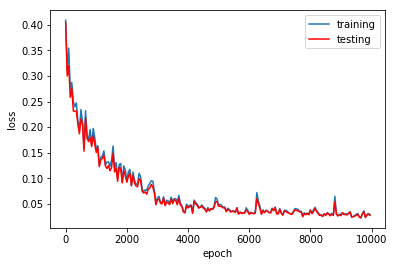

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

epochs = np.arange(len(all_losses))*plot_every
plt.figure()
handle1, = plt.plot(epochs,all_losses,label = 'training')
handle2, = plt.plot(epochs,test_losses, color='r',label = 'testing')
# handle2, = plt.plot(epochs,simple_baseline_losses, color='g',label = 'baseline')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [14]:
pytorch_total_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad )
print(pytorch_total_params)

5786403


In [15]:
torch.save(rnn.state_dict(),'RNN_1.pth')

In [4]:
rnn = RNN(input_size = 6, hidden_size = hidden_size, output_size = 3, model_type=model_type, \
          n_layers=n_layers,bidir = bidir).to(device)
rnn.load_state_dict(torch.load('RNN_1.pth'))

NameError: name 'RNN' is not defined

In [5]:
#For meta-testing, finetune, data
n_epochs = 6000
traj_batch = 5

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0
simple_baseline_losses = []
baseline_loss_avg = 0

#zero grad for optimizer
rnn_optimizer.zero_grad()

print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    #sample traj_batch trajectories
    train_input_data,train_output_data,val_input_data,val_output_data = \
        generate_random_data(traj_batch,metadataset.MTEST)
    
    loss = train(rnn, train_input_data,train_output_data, rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn,val_input_data,val_output_data)
    test_loss_avg += test_loss
    baseline_loss = eval_test_baseline(val_output_data)
    baseline_loss_avg += baseline_loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        simple_baseline_losses.append(baseline_loss_avg/plot_every)
        loss_avg = 0
        test_loss_avg = 0
        baseline_loss_avg = 0


NameError: name 'time' is not defined

In [6]:
def generate_all_data(all_trajs):
    """
    Output:
    ---------
    generates train and val input and output data in numpy array
    
    
    """
    indeces = np.arange(len(all_trajs))
    train_input_data = []
    train_output_data = []
    val_input_data = []
    val_output_data = []
    
    for i in indeces:
        train_input_traj = []
        train_output_traj = []
        val_input_traj = []
        val_output_traj = []
        
        timesteps,d = all_trajs[i].TrainInput.shape
        N = int(d/6)
        for j in range(N):
            if j == 0:
                train_input_traj.append(all_trajs[i].TrainInput[:,-6:])
                train_output_traj.append(all_trajs[i].TrainOutput[:,-3:])
                val_input_traj.append(all_trajs[i].ValInput[:,-6:])
                val_output_traj.append(all_trajs[i].ValOutput[:,-3:])
            else:
                train_input_traj.append(all_trajs[i].TrainInput[:,(j-1)*6:j*6])
                train_output_traj.append(all_trajs[i].TrainOutput[:,(j-1)*3:j*3])
                val_input_traj.append(all_trajs[i].ValInput[:,(j-1)*6:j*6])
                val_output_traj.append(all_trajs[i].ValOutput[:,(j-1)*3:j*3])
        train_input_data.append(train_input_traj)
        train_output_data.append(train_output_traj)
        val_input_data.append(val_input_traj)
        val_output_data.append(val_output_traj)
        
    return train_input_data,train_output_data,val_input_data,val_output_data




train_input_data,train_output_data,val_input_data,val_output_data = \
    generate_all_data(metadataset.MTEST)
loss = eval_test(rnn,val_input_data,val_output_data)
print('RMSE:',torch.sqrt(loss))
torch.save(rnn.state_dict(),'RNN_2.pth')

NameError: name 'metadataset' is not defined

NameError: name 'RNN' is not defined